# Designing MCA BIDS Event Files (from timing files)

Importing all the necessary OS, shell scripting and imaging operations:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import os
from os.path import join, dirname, abspath, isfile, isdir, split, splitext, exists, basename
import sys
import subprocess
import re
import glob
import argparse
import shutil
import json
import nibabel as nib
from nilearn import plotting
from nilearn.image import load_img, mean_img, new_img_like, resample_to_img, threshold_img, high_variance_confounds
from nilearn import datasets
from nilearn import maskers
from nilearn import signal
from nipype.interfaces.fsl.utils import ImageMeants
from nilearn.glm.first_level import FirstLevelModel
from nilearn.interfaces.fsl import get_design_from_fslmat
from statsmodels.stats.outliers_influence import variance_inflation_factor
from nilearn.plotting import plot_stat_map, plot_glass_brain, plot_epi, plot_contrast_matrix
from nilearn.plotting import plot_design_matrix, plot_anat, plot_img, plot_roi


In [53]:
%env

{'ANTSPATH': '/Users/vogtlab/ants/bin',
 'COMMAND_MODE': 'unix2003',
 'DISPLAY': '/private/tmp/com.apple.launchd.yMFDVx09Gh/org.xquartz:0',
 'FSLDIR': '/Users/vogtlab/fsl',
 'FSLGECUDAQ': 'cuda.q',
 'FSLMULTIFILEQUIT': 'TRUE',
 'FSLOUTPUTTYPE': 'NIFTI_GZ',
 'FSLTCLSH': '/Users/vogtlab/fsl/bin/fsltclsh',
 'FSLWISH': '/Users/vogtlab/fsl/bin/fslwish',
 'FSL_LOAD_NIFTI_EXTENSIONS': '0',
 'FSL_SKIP_GLOBAL': '0',
 'HDF5PATH': '/Users/vogtlab/hdf5/Contents/bin',
 'HOME': '/Users/vogtlab',
 'LOGNAME': 'vogtlab',
 'MATLABPATH': '/Applications/MATLAB_R2021b.app/bin',
 'MallocNanoZone': '0',
 'ORIGINAL_XDG_CURRENT_DESKTOP': 'undefined',
 'PATH': '/usr/local/bin:/Users/vogtlab/Library/Python/3.11/bin:/Applications/MATLAB/spm12/bin:/Applications/MATLAB_R2021b.app/bin::/Users/vogtlab/c3d/Contents/bin:/Users/vogtlab/ants/bin:/usr/local/lib/python3.11/site-packages:/Users/vogtlab/fsl/share/fsl/bin:/Users/vogtlab/fsl/share/fsl/bin:/Users/vogtlab/c3d/Contents/bin:/Users/vogtlab/ants/bin:/usr/local/lib/p

In [36]:
MCA_path = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/'
MCA_tmgpath = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/'
MCA_eventspath = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Events/'

## List of all timing files for RorK, FGT and SHK

In [6]:
# get all *RorK_words_FSL.txt files from MCA_eventspath
RorK_files = glob.glob(MCA_tmgpath + '*RorK_words_FSL.txt')
RorK_files.sort()
RorK_files

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA100_Ses1_Mem1_RorK_words_FSL.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA100_Ses1_Mem2_RorK_words_FSL.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA100_Ses2_Mem1_RorK_words_FSL.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA100_Ses2_Mem2_RorK_words_FSL.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA103_Ses1_Mem1_RorK_words_FSL.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA103_Ses1_Mem2_RorK_words_FSL.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA103_Ses2_Mem1_RorK_words_FSL.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA103_Ses2_Mem2_RorK_words_FSL.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA104_Ses1_Mem1_RorK_words_FSL.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA104_Ses1_Mem2_RorK_words_FSL.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA1

In [8]:
# get all *SF_words.txt files from MCA_eventspath
FGT_files = glob.glob(MCA_tmgpath + '*SF_words.txt')
FGT_files.sort()
FGT_files

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA100_Ses1_Mem1_SF_words.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA100_Ses1_Mem2_SF_words.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA100_Ses2_Mem1_SF_words.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA100_Ses2_Mem2_SF_words.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA103_Ses1_Mem1_SF_words.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA103_Ses1_Mem2_SF_words.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA103_Ses2_Mem1_SF_words.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA103_Ses2_Mem2_SF_words.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA104_Ses1_Mem1_SF_words.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA104_Ses1_Mem2_SF_words.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA104_Ses2_Mem1_SF_words.txt',
 '/Volumes/cerebro/Studies/MCA_F

In [9]:
# get all *shock_timings.txt files from MCA_eventspath
SHK_files = glob.glob(MCA_tmgpath + '*shock_timings.txt')
SHK_files.sort()
SHK_files

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA100_Ses1_Mem1_shock_timings.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA100_Ses1_Mem2_shock_timings.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA100_Ses2_Mem1_shock_timings.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA100_Ses2_Mem2_shock_timings.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA103_Ses1_Mem1_shock_timings.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA103_Ses1_Mem2_shock_timings.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA103_Ses2_Mem1_shock_timings.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA103_Ses2_Mem2_shock_timings.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA104_Ses1_Mem1_shock_timings.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA104_Ses1_Mem2_shock_timings.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA104_Ses2_Me

## MCA MEM BIDS Events Data
1. Session-Task-Conditions (consolidated events file for three conditions/trial_type chronologically for two tasks
    a. memorypart1  
    b. memorypart2
2. Session-Task-Condition (for initial trial set)

In [102]:
# create the combined _events.tsv files for BIDS framework for each subject, session and task; saving it in Combined_Events folder for now
for sub in range(7, 117):
    for ses in range(1, 3):
        for task in range(1, 3):
            # get the file names
            RorK_file = MCA_tmgpath + 'MCA' + str(sub) + '_Ses' + str(ses) + '_Mem' + str(task) + '_RorK_words_FSL.txt'
            FGT_file = MCA_tmgpath + 'MCA' + str(sub) + '_Ses' + str(ses) + '_Mem' + str(task) + '_SF_words.txt'
            SHK_file = MCA_tmgpath + 'MCA' + str(sub) + '_Ses' + str(ses) + '_Mem' + str(task) + '_shock_timings.txt'

            # print the file names
            print(RorK_file)
            print(FGT_file)
            print(SHK_file)

            # check if the files exist
            if exists(RorK_file) and exists(FGT_file) and exists(SHK_file):
                # read the files as pandas dataframes 
                RorK_df = pd.read_csv(RorK_file, sep='\t', header=None)
                # print(RorK_df)
                # append headers to the columns ['onset', 'duration', 'weights']
                RorK_df.columns = ['onset', 'duration', 'weights']
                # print(RorK_df)

                FGT_df = pd.read_csv(FGT_file, sep='\t', header=None)                   
                FGT_df.columns = ['onset', 'duration', 'weights']

                SHK_df = pd.read_csv(SHK_file, sep='\t', header=None)
                SHK_df.columns = ['onset', 'duration', 'weights']

                # for fixing bugs in the code
                # print(RorK_df)
                # print(FGT_df)
                # print(SHK_df)

                # check if the dataframes are not empty
                if not RorK_df.empty and not FGT_df.empty and not SHK_df.empty:
                    # drop the last columns if they are all ones (weights)
                    if RorK_df.iloc[:, -1].eq(1).all():
                        RorK_df = RorK_df.iloc[:, :-1]
                        # add a new column with the trial_type
                        RorK_df['trial_type'] = 'RorK'
                    if FGT_df.iloc[:, -1].eq(1).all():
                        FGT_df = FGT_df.iloc[:, :-1]
                        FGT_df['trial_type'] = 'FGT'
                    if SHK_df.iloc[:, -1].eq(1).all():
                        SHK_df = SHK_df.iloc[:, :-1]
                        SHK_df['trial_type'] = 'SHK'

                    # print(RorK_df)
                    # print(FGT_df)
                    # print(SHK_df)
                    
                    # concatenate the dataframes into one as new rows (axis=0)
                    df = pd.concat([RorK_df, FGT_df, SHK_df], axis=0)
                    # print(df)
                    # add headers to the columns
                    df.columns = ['onset', 'duration', 'trial_type']
                    # reset the index
                    df.reset_index(drop=True, inplace=True)

                    # sort the dataframe by the 'onset' column
                    df.sort_values(by='onset', inplace=True)

                    # print the dataframes
                    # print(RorK_df)
                    # print(FGT_df)
                    # print(SHK_df)

                    print(df)

                    # save the dataframe as a tsv file
                    combined_events_TSV = 'sub-' + str(sub).zfill(3) + '_ses-' + str(ses).zfill(2) + '_task-memorypart' + str(task) + '_events.tsv'
                    df.to_csv(MCA_eventspath + 'Combined_Events/' + combined_events_TSV, index=False, sep='\t')
                    print('Saved:', MCA_eventspath + 'Combined_Events/' + combined_events_TSV)

                    # corresponding json file for the tsv file is creted in the next loop when file checks are done from Combined_Events folder

                else:
                    print('Dataframes are empty')
            else:
                print('Timing File(s) do not exist')
            print('\n')


/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA7_Ses1_Mem1_RorK_words_FSL.txt
/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA7_Ses1_Mem1_SF_words.txt
/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/MCA7_Ses1_Mem1_shock_timings.txt
       onset  duration trial_type
1     8.6656       4.4        FGT
40   11.0656       2.0        SHK
2    20.4352       4.4        FGT
3    32.1872       4.4        FGT
41   34.5872       2.0        SHK
4    44.6576       4.4        FGT
42   47.0576       2.0        SHK
5    56.4768       4.4        FGT
6    68.1968       4.4        FGT
7    80.4160       4.4        FGT
43   82.8160       2.0        SHK
8    92.1520       4.4        FGT
9   103.8544       4.4        FGT
0   115.6064       4.4       RorK
10  127.4592       4.4        FGT
44  129.8592       2.0        SHK
11  139.9312       4.4        FGT
12  152.1504       4.4        FGT
45  154.5504       2.0        SHK
13  164.6224       4.4        FGT
14  176.4064       4.4       

In [21]:
MCA_eventspath

'/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Events/'

Copy BIDS-compliant files into available BIDS folders

In [34]:
for sub in range(95, 101):
    for ses in range(1, 3):
        for task in range(1, 3):
            # get the subject number
            subnum = str(sub).zfill(3)
            # get the session number
            sesnum = str(ses).zfill(2)
            # get the task number
            tasknum = str(task)
            # get the path to the events data
            events_file_name = 'sub-' + subnum + '_ses' + sesnum + '_task-memorypart' + tasknum + '_events.tsv' # missed hyphen for ses in first version
            events_file_path = MCA_eventspath + 'Combined_Events/' + events_file_name
            events_BIDS_path = MCA_path + 'MCA_BIDS_sample/' + 'sub-ID' + subnum + '/ses-' + sesnum + '/func/'
            events_TSV = 'sub-' + subnum + '_ses-' + sesnum + '_task-memorypart' + tasknum + '_events.tsv'
            events_JSON = 'sub-' + subnum + '_ses-' + sesnum + '_task-memorypart' + tasknum + '_events.json'
            print(events_BIDS_path)
            # check if the events file exists and if BIIDS folder exists
            if exists(events_file_path) and exists(events_BIDS_path):
                    print('Events file found')
                    # move the events file to the BIDS folder
                    shutil.copy(events_file_path, events_BIDS_path + events_TSV)
                    # create a json file for the events file
                    json_file = open(events_BIDS_path + events_JSON, 'w')
                    # json_file.write('{\n  "Onset": { \n "Description: "Stimulus onset time starts 24 seconds after the start of the trial" \n }; "Memory",\n  "RepetitionTime": 2.0\n}')
                    json_file.close()
                    print('Events file copied to this BIDS folder ' + events_BIDS_path)
            else:
                print('Events file not found/ BIDS path not available')
                print(events_file_path)

/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/MCA_BIDS_sample/sub-ID095/ses-01/func/
Events file found
Events file copied to this BIDS folder /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/MCA_BIDS_sample/sub-ID095/ses-01/func/
/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/MCA_BIDS_sample/sub-ID095/ses-01/func/
Events file found
Events file copied to this BIDS folder /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/MCA_BIDS_sample/sub-ID095/ses-01/func/
/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/MCA_BIDS_sample/sub-ID095/ses-02/func/
Events file not found/ BIDS path not available
/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Events/Combined_Events/sub-095_ses02_task-memorypart1_events.tsv
/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/MCA_BIDS_sample/sub-ID095/ses-02/func/
Events file not found/ BIDS path not available
/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Events/Combined_Events/sub-095_ses02_task-memorypart2_events.tsv
/Volumes/cerebro/Studies/MCA_FMRI/Public/Dat

# GLM Schematic Representation - template

In [ ]:
design_matrix = pd.read_csv('/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/NLA02/Pain_func1/NLA02_Pain1_Pre_01082024_192248.feat/filtered_func_data_reg_Stats_CmCr-n5_01192024_114200.feat/design.mat', delimiter='\t', engine='python')
design_matrix

In [13]:
glm_header = ['PainStim', 'PainStim_der', 'Motion1', 'Motion2', 'Motion3', 'Motion4', 'Motion5', 'Motion6', 'MotionOutlier', 'WM-CSF1', 'WM-CSF2', 'WM-CSF3', 'WM-CSF4', 'WM-CSF5']

In [25]:
# glm = get_design_from_fslmat('/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/NLA02/Pain_func1/NLA02_Pain1_Pre_01082024_192248.feat/filtered_func_data_reg_Stats_CmCr-n5_01192024_114200.feat/design.mat', column_names=None)
glm_24_2 = get_design_from_fslmat('/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/NLA24/Pain_func2/NLA24_Pain2_Pre_01082024_105037.feat/filtered_func_data_reg_Stats_CmCr-n5_01192024_114200.feat/design.mat', column_names=glm_header)
glm_24_2

,PainStim,PainStim_der,Motion1,Motion2,Motion3,Motion4,Motion5,Motion6,MotionOutlier,WM-CSF1,WM-CSF2,WM-CSF3,WM-CSF4,WM-CSF5
0,0.000432,0.001321,-0.006232,0.000286,0.002246,-0.158097,-0.262990,-0.571085,2.434295,-0.370568,-2.999925,0.922435,-2.482751,-0.000034
1,0.001945,0.001217,-0.005267,0.000656,0.001351,-0.100805,-0.129577,-0.263743,1.117013,0.148882,-1.224075,0.382823,-0.568414,-0.000034
2,0.003251,0.000965,-0.002222,-0.000165,0.000164,-0.017164,0.157188,0.117047,-0.507475,0.722705,0.470433,-0.150818,-0.176656,-0.000034
3,0.004261,0.000634,-0.001348,0.000639,-0.000215,-0.033146,-0.005240,0.024543,-0.390560,0.351657,0.515529,-0.319497,0.984169,-0.000034
4,0.004904,0.000235,-0.001072,0.000556,-0.000247,-0.032209,-0.026327,0.077040,-0.120443,0.339184,0.372240,-0.307136,0.749627,-0.000034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,0.031672,0.004728,-0.001780,0.000071,-0.000065,-0.075909,-0.160180,0.035263,-0.107091,0.358248,-0.122663,0.028355,0.708232,-0.000034
221,0.036030,0.003605,0.000399,0.000429,-0.000639,-0.042378,-0.137904,0.038824,0.299066,0.078920,-0.047810,-0.098664,0.474307,-0.000034
222,0.039272,0.002497,0.001732,0.000517,-0.001101,0.011181,0.060865,0.145779,-0.156844,0.017973,0.136252,-0.177790,-0.149912,-0.000034
223,0.041413,0.001403,0.001671,0.000998,-0.001239,0.016913,0.075061,0.144708,-0.331277,0.084387,0.497855,-0.215088,0.208701,-0.000034


<Axes: label='conditions', ylabel='scan number'>

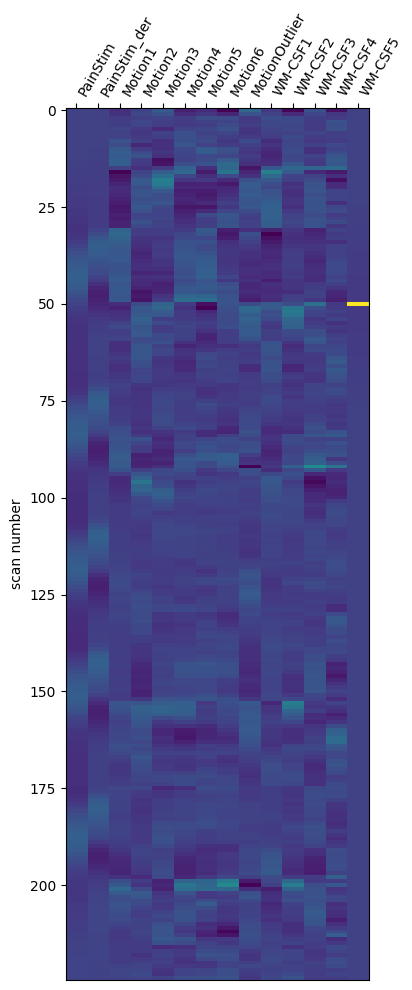

In [28]:
plot_design_matrix(glm_24_2)

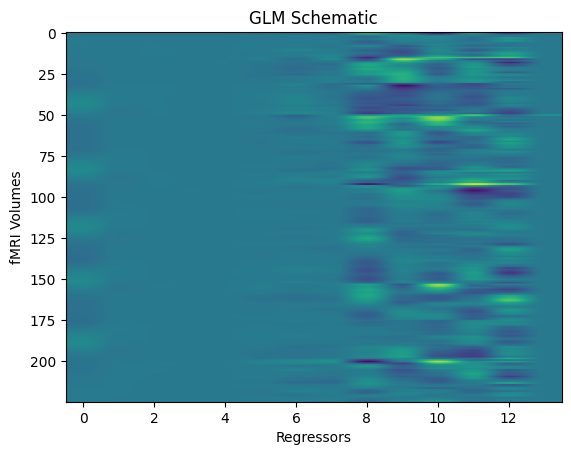

In [26]:
plot_design_matrix(glm_24_2)

<Axes: label='conditions', ylabel='scan number'>

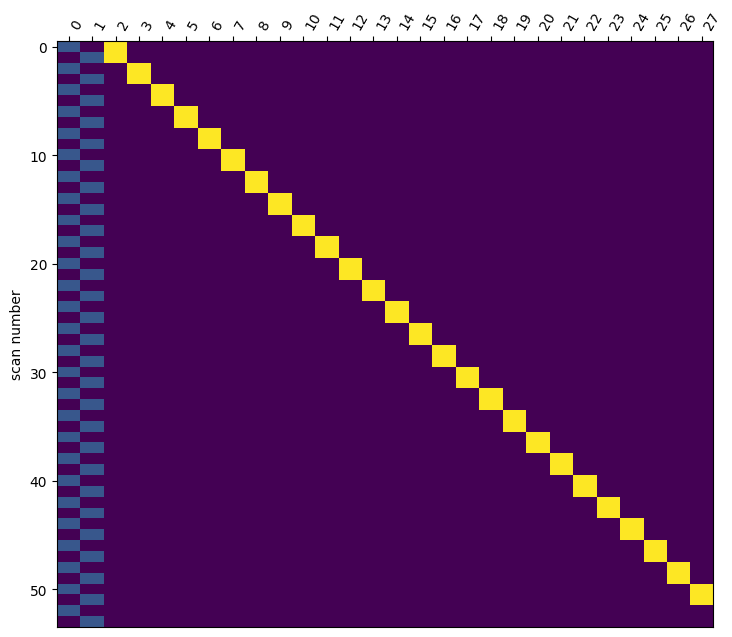

In [36]:
#plot gp_stats model
gp_stats = '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/Group_Analysis/Gp_Ana_n27_z2-p05_ME12_fdrms1pt5_CmCr-n5_02072024_112000.gfeat/cope1.feat/design.mat'
gp_stats = get_design_from_fslmat(gp_stats, column_names=None)
plot_design_matrix(gp_stats)
